In [376]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean, RollingStd
import mlflow
from mlflow.models import infer_signature
import copy
from utilsforecast.losses import rmse, mae
from utilsforecast.evaluation import evaluate
import mlforecast.flavor



df = pd.read_csv('daily_demand.csv', parse_dates = ['fecha'])
df['dia_festivo'].astype('category')
df['dia_semana'].astype('category')
df.drop(['monto_total','semana_ano', 'mes', 'trimestre', 'ano','semana_inicio','dia_semana','lag_1','lag_7'], axis = 1, inplace = True)


horizon = 30
valid = df.groupby('platillo_id').tail(horizon)
train = df.drop(valid.index)
train.shape, valid.shape

'''

stats = []
for pid, g in train.groupby('platillo_id'):
    s = g.sort_values('fecha')['cantidad']
    stats.append({
        'platillo_id':    pid,
        'mean_sales':     s.mean(),
        'std_sales':      s.std(),
        'var_sales':      s.var(),
        'cv_sales':       s.std()/s.mean() if s.mean() else 0,
        'spike_count':    (s > s.mean() + 2*s.std()).sum(),
        'zero_days_ratio':(s == 0).mean(),
    })
stats_df = pd.DataFrame(stats)

# 5) Fit scaler y PCA en train → embeddings
num_cols = ['mean_sales','std_sales','var_sales','cv_sales','spike_count','zero_days_ratio']
scaler = StandardScaler().fit(stats_df[num_cols].fillna(0))
X_train_stats = scaler.transform(stats_df[num_cols].fillna(0))

pca_dummy = PCA().fit(X_train_stats)
cum_var = np.cumsum(pca_dummy.explained_variance_ratio_)
k = np.searchsorted(cum_var, 0.95) + 1
pca = PCA(n_components=k, random_state=42).fit(X_train_stats)
emb_train = pca.transform(X_train_stats)

emb_df_train = pd.DataFrame(
    emb_train,
    columns=[f'pca_emb_{i}' for i in range(k)]
)
emb_df_train['platillo_id'] = stats_df['platillo_id']

train = train.merge(emb_df_train, on='platillo_id')
valid = valid.merge(emb_df_train, on='platillo_id')

'''


"\n\nstats = []\nfor pid, g in train.groupby('platillo_id'):\n    s = g.sort_values('fecha')['cantidad']\n    stats.append({\n        'platillo_id':    pid,\n        'mean_sales':     s.mean(),\n        'std_sales':      s.std(),\n        'var_sales':      s.var(),\n        'cv_sales':       s.std()/s.mean() if s.mean() else 0,\n        'spike_count':    (s > s.mean() + 2*s.std()).sum(),\n        'zero_days_ratio':(s == 0).mean(),\n    })\nstats_df = pd.DataFrame(stats)\n\n# 5) Fit scaler y PCA en train → embeddings\nnum_cols = ['mean_sales','std_sales','var_sales','cv_sales','spike_count','zero_days_ratio']\nscaler = StandardScaler().fit(stats_df[num_cols].fillna(0))\nX_train_stats = scaler.transform(stats_df[num_cols].fillna(0))\n\npca_dummy = PCA().fit(X_train_stats)\ncum_var = np.cumsum(pca_dummy.explained_variance_ratio_)\nk = np.searchsorted(cum_var, 0.95) + 1\npca = PCA(n_components=k, random_state=42).fit(X_train_stats)\nemb_train = pca.transform(X_train_stats)\n\nemb_df_train 

In [391]:
params = {
    'init': {
        'models': {
            'lgb': lgb.LGBMRegressor(
                verbosity = -1, bagging_fraction = 0.8, feature_fraction = 0.8,
                lambda_l1 = 0.1, lambda_l2 = 0, learning_rate = 0.05,
                max_depth = -1, num_leaves = 31, objective = 'tweedie', metric = 'rmse'
            ),
            'xgb': xgb.XGBRegressor(
                objective = 'reg:squarederror', n_estimators = 200, learning_rate = 0.05,
                max_depth = 6, verbosity = 0
            ),
            'catboost': CatBoostRegressor(
                iterations = 200, learning_rate = 0.05,
                depth = 6, verbose = 0, objective = 'RMSE'
            ),
            'randomforest': RandomForestRegressor(
                n_estimators = 100, max_depth = 10, n_jobs = -1,
                random_state = 42
            )
        },
        'freq': 'D',
        'lags': [1, 7, 14, 28],
        'lag_transforms': {
            1: [ExpandingMean(), RollingStd(window_size=7)],
            7: [RollingMean(window_size=7)],
            14: [RollingMean(window_size=14)],
            28: [RollingMean(window_size=28)]
        },
        'date_features': ['dayofweek'],
    },
    'fit': {
        'id_col':'platillo_id',
        'time_col': 'fecha',
        'target_col': 'cantidad',
        'static_features':[],
    }
}

In [392]:
fcst = MLForecast(**params['init'])
fcst.fit(train, **params['fit'])
X_valid = valid[['platillo_id', 'fecha', 'ocupacion', 'dia_festivo']]
preds = fcst.predict(horizon, X_df = X_valid)

df_compare = valid[['platillo_id', 'fecha', 'cantidad']].merge(
    preds,
    on=['platillo_id', 'fecha'],
    how='left'
)

df_compare = df_compare.rename(columns={
    'cantidad': 'y'
})

eval_result = evaluate(
    df_compare,
    metrics=[rmse, mae],
    id_col='platillo_id',
    time_col='fecha',
    target_col='y',
    agg_fn = 'mean'
)

X_example = (fcst.make_future_dataframe(horizon).merge(valid[['platillo_id','fecha','ocupacion','dia_festivo'] ],on=['platillo_id','fecha'],how='left'))
y_example = fcst.predict(horizon, X_df=X_example)
signature = infer_signature(X_example, y_example)

/Users/axllopez/Desktop/OneDrive _Instituto Tecnologico_y_de_Estudios_Superiores_de_Monterrey/OCTAVO/Proyecto IDM/Oumaji_Final_Project/.venv/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [316]:
mlflow.set_tracking_uri("http://localhost:5001")
mlflow.set_experiment("Oumaji_Demand")

with mlflow.start_run():
    logged_params = copy.deepcopy(params) 
    logged_params['init']['models'] = {
        k: (v.__class__.__name__, v.get_params())
        for k, v in params['init']['models'].items()
    }
    mlflow.log_params(logged_params)
    models = fcst.models_.keys()
    logged_metrics = {}
    for _, row in eval_result.iterrows():
        metric = row['metric']
        for model in models:
            logged_metrics[f'{metric}_{model}'] = row[model]
    mlflow.log_metrics(logged_metrics)
    mlforecast.flavor.log_model(model=fcst, 
                                artifact_path="model",
                                signature=signature,
                                input_example=X_example,
                                registered_model_name = "MLForecast")

2025/05/23 18:15:07 WARNING mlflow.utils.requirements_utils: Failed to run predict on input_example, dependencies introduced in predict are not captured.
MlflowException('The provided prediction DataFrame contains 2790 rows. Only 1 row should be supplied.')Traceback (most recent call last):
  File "/Users/axllopez/Desktop/OneDrive _Instituto Tecnologico_y_de_Estudios_Superiores_de_Monterrey/OCTAVO/Proyecto IDM/Oumaji_Final_Project/.venv/lib/python3.11/site-packages/mlflow/utils/_capture_modules.py", line 166, in load_model_and_predict
    model.predict(input_example, params=params)
  File "/Users/axllopez/Desktop/OneDrive _Instituto Tecnologico_y_de_Estudios_Superiores_de_Monterrey/OCTAVO/Proyecto IDM/Oumaji_Final_Project/.venv/lib/python3.11/site-packages/mlforecast/flavor.py", line 339, in predict
    raise MlflowException(
mlflow.exceptions.MlflowException: The provided prediction DataFrame contains 2790 rows. Only 1 row should be supplied.
2025/05/23 18:15:07 WARNING mlflow.utils.e

🏃 View run monumental-foal-129 at: http://localhost:5001/#/experiments/400716610318719328/runs/f19b3c09457747e9b85547775be1f31e
🧪 View experiment at: http://localhost:5001/#/experiments/400716610318719328


Created version '1' of model 'MLForecast'.


In [393]:
eval_result

,metric,lgb,xgb,catboost,randomforest
0,rmse,5.523345,5.659956,5.523218,5.904230
1,mae,4.115172,4.214565,4.068753,4.522136


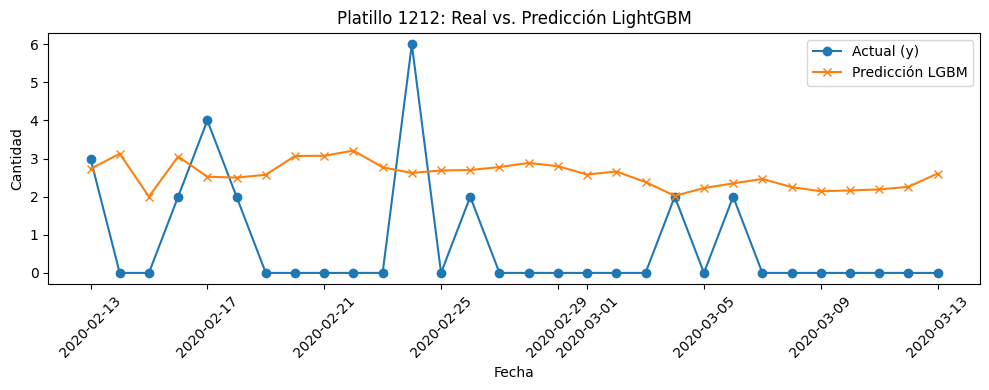

In [395]:
import matplotlib.pyplot as plt

# 1. Filtrar sólo el platillo 1212
df_1212 = df_compare[df_compare['platillo_id'] == 310].copy()
# 3. Graficar comparación
plt.figure(figsize=(10, 4))
plt.plot(df_1212['fecha'], df_1212['y'],    marker='o', label='Actual (y)')
plt.plot(df_1212['fecha'], df_1212['lgb'],  marker='x', label='Predicción LGBM')
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.title('Platillo 1212: Real vs. Predicción LightGBM')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()